In [2]:
import numpy as np
import pandas as pd
import pickle
import time
import itertools

import matplotlib
matplotlib.rcParams.update({'font.size': 17.5})

import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rc('axes.formatter', useoffset=False)


import sys
import os.path
sys.path.append( os.path.abspath(os.path.join( os.path.dirname('..') , os.path.pardir )) )

In [3]:
#import FLAME with parameter for the number of important covariates
from colFLAMEbit_imp import *
from FLAMEbit_imp import *


In [4]:
def construct_sec_order(arr):
    ''' an intermediate data generation function used 
        for generating second order information '''
    
    second_order_feature = []
    num_cov_sec = len(arr[0])
    for a in arr:
        tmp = []
        for i in range(num_cov_sec):
            for j in range(i+1, num_cov_sec):
                tmp.append( a[i] * a[j] )
        second_order_feature.append(tmp)
        
    return np.array(second_order_feature)



In [5]:
def data_generation_dense_2(num_control, num_treated, num_cov_dense, 
                            num_covs_unimportant, control_m = 0.1,
                            treated_m = 0.9):
    
    ''' the data generating function that we will use; 
        includes second order information '''
    

    # generate data for control group 
    xc = np.random.binomial(1, 0.5, size=(num_control, num_cov_dense)) #bernouilli
    
    # generate data for treated group 
    xt = np.random.binomial(1, 0.5, size=(num_treated, num_cov_dense))   #bernouilli
     
    
    errors1 = np.random.normal(0, 0.1, size=num_control)    # some noise
    
    errors2 = np.random.normal(0, 0.1, size=num_treated)    # some noise
    
    dense_bs_sign = np.random.choice([-1,1], num_cov_dense) 
    
    dense_bs = [ np.random.normal(s * 10, 1) for s in dense_bs_sign ]   #alpha in the paper

    # y for control group 
    yc = np.dot(xc, np.array(dense_bs)) #+ errors1     
       
    # y for treated group 
    treatment_eff_coef = np.random.normal( 1.5, 0.15, size=num_cov_dense) #beta
    treatment_effect = np.dot(xt, treatment_eff_coef) 
    
    second = construct_sec_order(xt[:,:(num_covs_unimportant -1)])
    treatment_eff_sec = np.sum(second, axis=1)
    
    yt = np.dot(xt,np.array(dense_bs))+treatment_effect+treatment_eff_sec 
                                      # + errors2    

    # generate unimportant covariates for control group
    xc2 = np.random.binomial(1, control_m, size=(num_control,
                                                 num_covs_unimportant))  
    
    # generate unimportant covariates for treated group
    xt2 = np.random.binomial(1, treated_m, size=(num_treated,
                                                 num_covs_unimportant))   
        
    df1 = pd.DataFrame(np.hstack([xc, xc2]), 
                       columns=range(num_cov_dense + num_covs_unimportant))
    df1['outcome'] = yc
    df1['treated'] = 0

    df2 = pd.DataFrame(np.hstack([xt, xt2]), 
                       columns=range(num_cov_dense + num_covs_unimportant)) 
    df2['outcome'] = yt
    df2['treated'] = 1

    df = pd.concat([df1,df2])
    df['matched'] = 0
  
    return df, dense_bs, treatment_eff_coef




In [6]:
# data generation:  5 important covariates, 10 unimportant covariates

d = data_generation_dense_2(15000, 15000, 5,10, control_m = 0.1, treated_m = 0.9)
df = d[0] 
holdout,_,_ = data_generation_dense_2(15000, 15000, 5,10, control_m = 0.1, treated_m = 0.9)
d[0].to_csv('411datatest.csv')

In [7]:
#run generic flame til no more matches

res_gen = run_bit(df, holdout, range(15), [2]*15, covs_unimportant = -10, threshold = -10, tradeoff_param = 0.001)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
30000
-0.6289692414473487
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14]
29994
-0.6286705110408303
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14]
29982
-0.6285500005888557
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12]
29910
-0.628497973565509
[0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12]
29741
-0.6284342679501671
[0, 1, 2, 3, 4, 6, 7, 9, 10, 11]
29194
-0.62838634737416
[0, 1, 2, 3, 4, 7, 9, 10, 11]
28240
-0.6283491890784525
[0, 1, 2, 3, 4, 7, 9, 10]
26772
-0.6282950240911057
[0, 1, 2, 3, 4, 9, 10]
24160
-0.6281965295977631
[0, 1, 2, 3, 4, 10]
19506
-0.6270555953634128
[0, 1, 2, 3, 4]
3719
-29.07484275190548
[1, 2, 3, 4]
2960
-62.29389002995944
[1, 2, 4]
2960
-96.69747768970564
[2, 4]
no more matches


In [8]:
# run collapsing flame til no more matches

res = run_mpbit(df, holdout, range(15), [2]*15, covs_unimportant=-10, threshold =-10, tradeoff_param = 0.001)


no more matches


In [9]:
#save data and result from generic and collapsing FLAME to compare to other methods
pickle.dump(res_gen, open('411genendrestest', 'wb'))
pickle.dump(res, open('411colendrestest', 'wb'))
pickle.dump(d, open('411datatest', 'wb'))

d[0].to_csv('411data.csv')

In [10]:
# define a ground truth
def ground_truth( eff_coef, covs_ordered, num_covs_dense = 5, num_second_order = 10, second_order = True):
    arr = np.array(list(itertools.product([0,1], repeat=num_covs_dense)))
    effect = np.dot(arr, eff_coef)
    if second_order:
        second_effect = np.sum(construct_sec_order(arr[:,:num_second_order] ), axis=1)
        effect = effect + second_effect
    df = pd.DataFrame(arr, columns=covs_ordered)
    df['effect'] = effect
    return df


In [11]:
# generate ground truth data
ground_truth = ground_truth(d[2], list(range(5)), num_covs_dense = 5, num_second_order = 10, second_order = True)
ground_truth.to_csv('411groundtruthtest.csv')


In [12]:
# get true and estimated cates for matched units
truth_list = []
pred_list = []
count = 0
av_err_cate = []
aux_size = []
for r in res[1]:
    count = count +1
    tmp = pd.merge(r, ground_truth, on = list(set(range(5)) & set(r.columns) ), how = 'left')
    truth_list = truth_list + list(tmp['effect_y'])
    pred_list = pred_list + list(tmp['effect_x'])
    aux_size = aux_size + list(tmp['size'])


truth_list_gen = []
pred_list_gen = []

aux_size_gen = []
av_err_cate_gen = []
for r_gen in res_gen[1]:
    tmp_gen = pd.merge(r_gen, ground_truth, on = list(set(range(5)) & set(r_gen.columns) ), how = 'left')
    truth_list_gen = truth_list_gen + list(tmp_gen['effect_y'])
    pred_list_gen = pred_list_gen + list(tmp_gen['effect_x'])
    aux_size_gen = aux_size_gen + list(tmp_gen['size'])



In [30]:
# create a dataframe with the true and estimated cates : data to be used in R for nice plots and compare other methods


effect_col = pd.DataFrame()
effect_col['pred'] = pred_list
effect_col['true'] = truth_list
effect_col['size'] = aux_size

effect_col['method'] = ['collapsing FLAME']*len(truth_list)


#effect_col.to_csv('effect411endcol.csv')

effect_gen = pd.DataFrame()
effect_gen['pred'] = pred_list_gen
effect_gen['true'] = truth_list_gen
effect_gen['method'] = ['generic FLAME']*len(truth_list_gen)
effect_gen['size'] = aux_size_gen


effect = pd.concat([effect_gen, effect_col])
effect_gen.to_csv('effect411endgen.csv')

effect.to_csv('effect411end.csv')




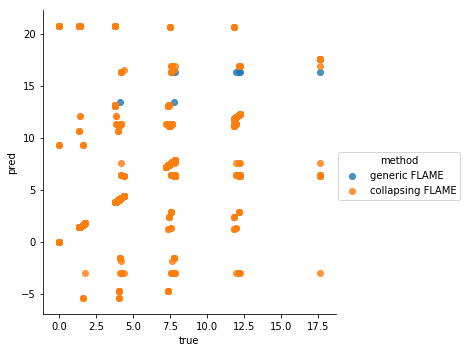

In [31]:
#-----PLOT generic FLAME and collapsing FLAME in same figure----------#

import seaborn as sns
sns.lmplot(x="true", y="pred",hue="method", data = effect, fit_reg=False)


In [21]:
#----------- early stopping----------------#

In [22]:
#run generic flame before dropping important covariates
res_genearly = run_bit(df, holdout, range(15), [2]*15, covs_unimportant = 10, threshold = -10, tradeoff_param = 0.001)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
30000
-0.6289692414473487
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14]
29994
-0.6286705110408303
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14]
29982
-0.6285500005888557
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12]
29910
-0.628497973565509
[0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12]
29741
-0.6284342679501671
[0, 1, 2, 3, 4, 6, 7, 9, 10, 11]
29194
-0.62838634737416
[0, 1, 2, 3, 4, 7, 9, 10, 11]
28240
-0.6283491890784525
[0, 1, 2, 3, 4, 7, 9, 10]
26772
-0.6282950240911057
[0, 1, 2, 3, 4, 9, 10]
24160
-0.6281965295977631
[0, 1, 2, 3, 4, 10]
19506
-0.6270555953634128
all important covariate dropped


In [23]:
# run collapsing flame efore dropping important covariates
researly = run_mpbit(df, holdout, range(15), [2]*15, covs_unimportant=10, threshold =-10, tradeoff_param = 0.001)

all important covariate dropped


In [ ]:
pickle.dump(res_genearly, open('411genendrestestearly', 'wb'))
pickle.dump(researly, open('411colendrestestearly', 'wb'))


In [24]:
# get true and estimated cates for matched units
truth_liste = []
pred_liste = []
count = 0
av_err_catee = []
aux_sizee = []
for r in researly[1]:
    count = count +1
    tmp = pd.merge(r, ground_truth, on = list(set(range(5)) & set(r.columns) ), how = 'left')
    truth_liste = truth_liste + list(tmp['effect_y'])
    pred_liste = pred_liste + list(tmp['effect_x'])
    aux_sizee = aux_sizee + list(tmp['size'])


truth_list_gene = []
pred_list_gene = []

aux_size_gene = []
for r_gen in res_genearly[1]:
    tmp_gen = pd.merge(r_gen, ground_truth, on = list(set(range(5)) & set(r_gen.columns) ), how = 'left')
    truth_list_gene = truth_list_gene + list(tmp_gen['effect_y'])
    pred_list_gene = pred_list_gene + list(tmp_gen['effect_x'])
    aux_size_gene = aux_size_gene + list(tmp_gen['size'])



In [25]:
# create a dataframe with the true and estimated cates : data to be used in R for plots


effect_col = pd.DataFrame()
effect_col['pred'] = pred_liste
effect_col['true'] = truth_liste
effect_col['size'] = aux_sizee

effect_col['method'] = ['collapsing FLAME']*len(truth_liste)


effect_col.to_csv('effect411earlycoltest.csv')

effect_gen = pd.DataFrame()
effect_gen['pred'] = pred_list_gene
effect_gen['true'] = truth_list_gene
effect_gen['method'] = ['generic FLAME']*len(truth_list_gene)
effect_gen['size'] = aux_size_gene


effect = pd.concat([effect_gen, effect_col])
effect_gen.to_csv('effect411earlygentest.csv')

effect.to_csv('effect411earlytest.csv')

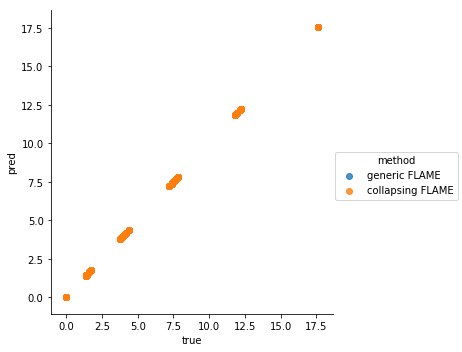

In [27]:
#-----PLOT generic FLAME and collapsing FLAME in same figure----------#

import seaborn as sns
sns.lmplot(x="true", y="pred",hue="method", data = effect, fit_reg=False)


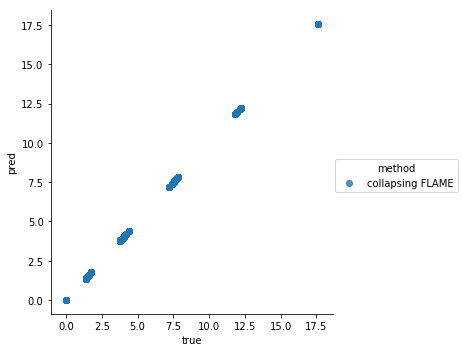

In [28]:
sns.lmplot(x="true", y="pred",hue="method", data = effect_col, fit_reg=False)


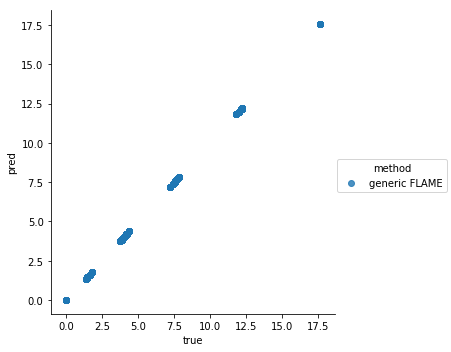

In [29]:
sns.lmplot(x="true", y="pred",hue="method", data = effect_gen, fit_reg=False)
